In [1]:
# dependencies and setup
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
from scipy.stats import linregress

# raw data files
ardd_path = "../data_raw/ardd_fatalities Sep 2020.csv"

# assign csv info into ardd
ardd = pd.read_csv(ardd_path,header=0,dtype={"Speed Limit":"string",
                                             "National Remoteness Areas": "string",
                                             "SA4 Name 2016": "string",
                                             "National LGA Name 2017": "string",
                                             "National Road Type": "string"})

# preview data
ardd.head(1)

,Crash ID,State,Month,Year,Dayweek,Time,Crash Type,Bus Involvement,Heavy Rigid Truck Involvement,Articulated Truck Involvement,...,Age,National Remoteness Areas,SA4 Name 2016,National LGA Name 2017,National Road Type,Christmas Period,Easter Period,Age Group,Day of week,Time of day
0,20202012,Vic,9,2020,Monday,3:11,Single,-9,-9,-9,...,16,Inner Regional Australia,Bendigo,Greater Bendigo (C),National or State Highway,No,No,0_to_16,Weekend,Night


In [2]:
# remove unwanted columns "National Remoteness Areas","SA4 Name 2016","National LGA Name 2017","National Road Type"
clean_ardd = ardd.drop(columns=["National Remoteness Areas","SA4 Name 2016","National LGA Name 2017","National Road Type"])

# gather latest and earliest year for the title in graphs
min_year = clean_ardd["Year"].min()
max_year = clean_ardd["Year"].max()

# replace the "_" with " " in column "Age Group"
clean_ardd["Age Group"] = clean_ardd["Age Group"].str.replace("_"," ")

# remove the ":" in column "Time"
clean_ardd["Time"] = clean_ardd["Time"].str.replace(":","")

# replace "-9" with Unknown as described in the data dictionary
clean_ardd=clean_ardd.replace({"-9":"Unknown"}).replace({-9: "Unknown"})

# change data type from String to Int
clean_ardd['Year'] = clean_ardd['Year'].astype(int)

# remove rows with Unknown time
clean_ardd = clean_ardd[clean_ardd.Time != "Unknown"]
clean_ardd.head(1)

,Crash ID,State,Month,Year,Dayweek,Time,Crash Type,Bus Involvement,Heavy Rigid Truck Involvement,Articulated Truck Involvement,Speed Limit,Road User,Gender,Age,Christmas Period,Easter Period,Age Group,Day of week,Time of day
0,20202012,Vic,9,2020,Monday,311,Single,Unknown,Unknown,Unknown,Unknown,Passenger,Male,16,No,No,0 to 16,Weekend,Night


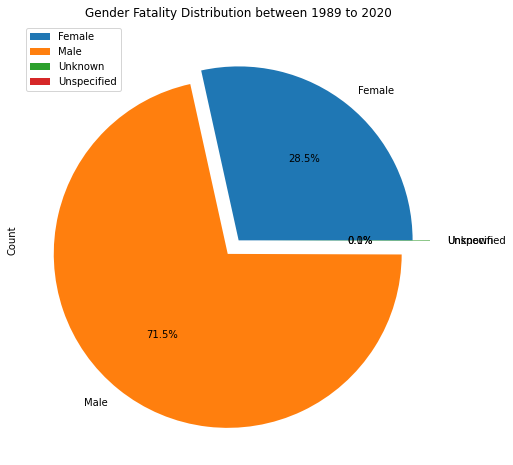

In [3]:
# capture the requried Gender and Crash ID into gender_df
gender_df = clean_ardd[["Crash ID","Gender"]]
groupby_gender = gender_df.groupby(["Gender"])

# calculate count
count = groupby_gender["Crash ID"].count()

# create a dataframe to hold Sex and Count
groupby_gender_df = pd.DataFrame({"Count": count
                           })

# set the explode value
explode=[0,0.1,0.1,0.1]
plot = groupby_gender_df.plot.pie(y="Count",explode = explode, figsize=(8,8), startangle=0, autopct="%1.1f%%")
plt.title(f"Gender Fatality Distribution between {min_year} to {max_year}")
plt.savefig('../output_data/cay_gender_fatality_distribution.png', facecolor = 'w')
plt.show()

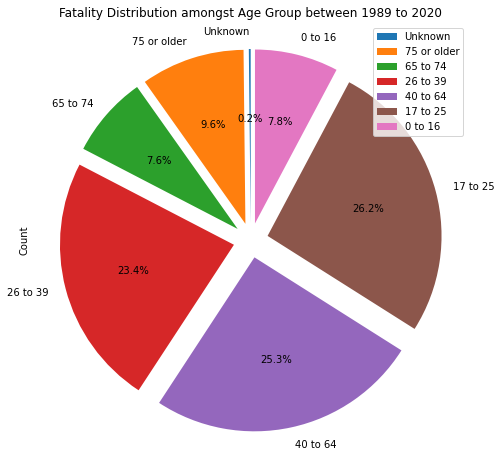

In [4]:
# Generate a pie plot showing the distribution of age group versus crashes using pandas
ageg_df = clean_ardd[["Crash ID","Age Group"]]
groupby_ageg = ageg_df.groupby(["Age Group"])

# calculate count
count = groupby_ageg["Crash ID"].count()

# create a dataframe to hold Age Group and Count
groupby_ageg_df = pd.DataFrame({"Count": count
                           })

groupby_ageg_df = groupby_ageg_df.reindex(['Unknown','75 or older', '65 to 74', '26 to 39', '40 to 64', '17 to 25' ,'0 to 16'])

# set the explode value
explode=[0.1,0.1,0.1,0.1,0.1,0.1,0.1]

plot = groupby_ageg_df.plot.pie(y="Count",explode = explode, figsize=(8,8), startangle=90, autopct="%1.1f%%")
plt.title(f"Fatality Distribution amongst Age Group between {min_year} to {max_year}")
plt.savefig('../output_data/cay_fatality_distribution_by_age_group', facecolor = 'w')

plt.show()

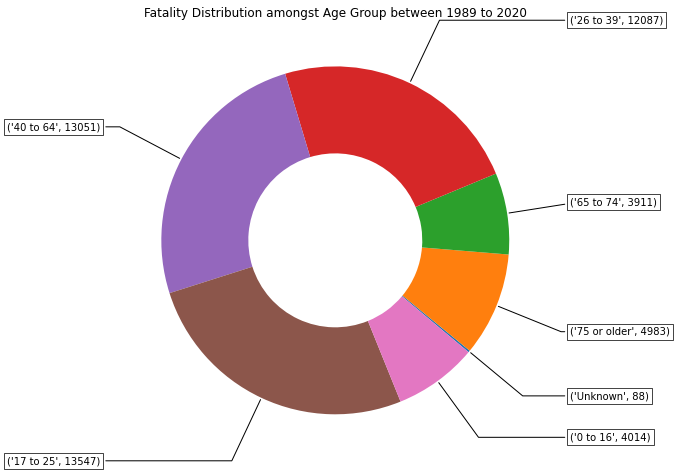

In [5]:
# create a second view with donut chart
fig, ax = plt.subplots(figsize=(8,8), subplot_kw=dict(aspect="equal"))

wedges, texts = ax.pie(groupby_ageg_df["Count"], wedgeprops=dict(width=0.5), startangle=-40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate((groupby_ageg_df.index[i],groupby_ageg_df["Count"][i]), xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)

ax.set_title(f"Fatality Distribution amongst Age Group between {min_year} to {max_year}")
plt.savefig('../output_data/cay_fatality_distribution_by_age_group(donut).png.png', facecolor = 'w')
plt.show()


## Time vs Deaths since 2010

In [6]:
# capture fatality data after year 2010
time_fatality_df = clean_ardd.loc[clean_ardd['Year'] >= 2010]
time_fatality_df = clean_ardd.Time.value_counts().reset_index().rename(columns={'index': 'Time', 'Time': 'Count'})

# update data type to integer
time_fatality_df['Time'] = time_fatality_df['Time'].astype(int)

# sort result by Time
time_fatality_df = time_fatality_df.sort_values(by='Time', ascending=True)

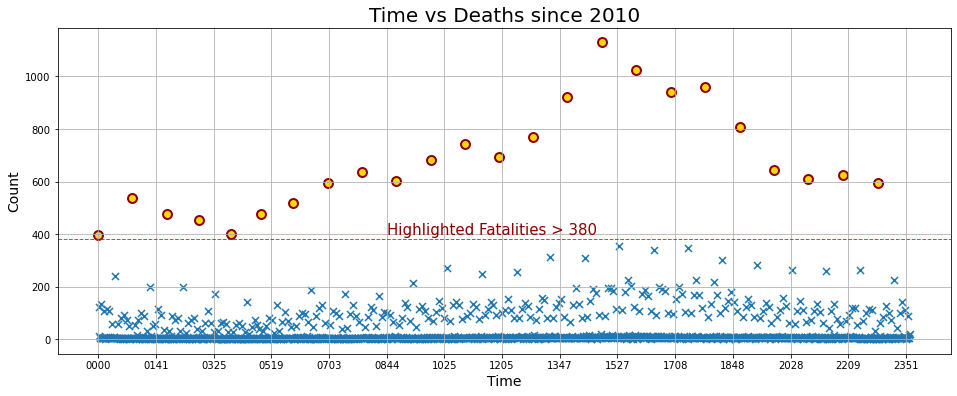

In [7]:
# plot graph to show Time vs Deaths after 2010
fig, ax = plt.subplots(figsize=(16, 6))

# arrange the x interval
plt.xticks(np.arange(0, 2400, step=100))

plt.scatter(time_fatality_df['Time'].map("{:04}".format),time_fatality_df['Count'], s= 50 ,marker = "x")
plt.title('Time vs Deaths since 2010',fontsize =20)
plt.xlabel('Time',fontsize =14)
plt.ylabel('Count',fontsize =14)
ax.grid()

# highlight the number of fatalities that's with the greatest trend
outlier_time_fatality_df = time_fatality_df.query('Count >= 380')
plt.scatter(outlier_time_fatality_df["Time"].map("{:04}".format), outlier_time_fatality_df["Count"],s=80,
            alpha=1, color="gold" , marker="o", edgecolors="darkred",linewidths=2)
plt.axhline(y=380, color='r', linestyle="dashed",linewidth=1, alpha=0.8)
plt.annotate("Highlighted Fatalities > 380",(500,400),fontsize=15,color="darkred")
plt.savefig('../output_data/cay_time_vs_deaths.png', facecolor = 'w')
plt.show()

## Day of Week vs. Fatality

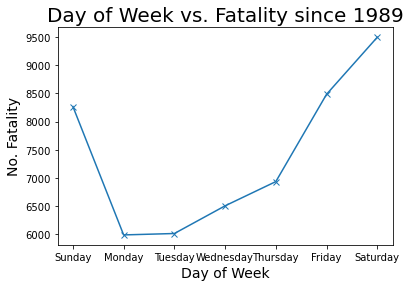

In [8]:
# Generate a pie plot showing the distribution of dayweek versus number of crashes using pandas
dc_df = clean_ardd[["Dayweek","Crash ID"]]

# group by the Day of Week and count the number of fatality
groupby_dayweek = dc_df.groupby(["Dayweek"])

# calculate count
count = groupby_dayweek["Crash ID"].count()

# create a dataframe to hold Day of week and Count
groupby_dayweek_df = pd.DataFrame({"Count": count
                           })

# manually rearrange the Day of Week index
groupby_dayweek_df = groupby_dayweek_df.reindex(['Sunday','Monday', 'Tuesday', 'Wednesday', 'Thursday','Friday','Saturday'])

# plot the graph
plt.plot(groupby_dayweek_df, marker = "x")

plt.title(f"Day of Week vs. Fatality since {min_year}",fontsize =20)
plt.ylabel("No. Fatality",fontsize =14)
plt.xlabel("Day of Week",fontsize =14)
plt.savefig('../output_data/cay_day_of_week_vs_fatality.png', facecolor = 'w')
plt.show()

## Speed limit vs. No. of Deaths

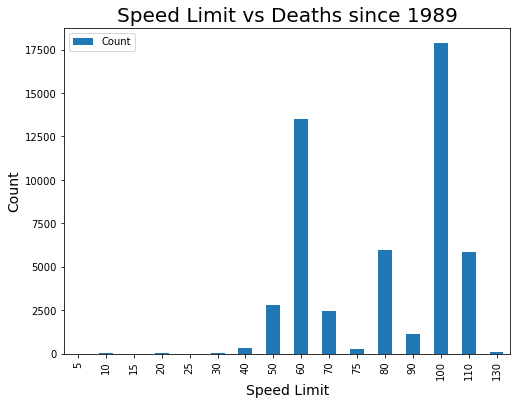

In [9]:
# capture Speed Limit and Crash ID into new dataframe
spdlmt_df = clean_ardd[["Speed Limit","Crash ID"]]

# remove "unknown", "unspecified" and "<40"
spdlmt_df = spdlmt_df[(spdlmt_df["Speed Limit"] != "Unknown") 
                      & (spdlmt_df["Speed Limit"] != "Unspecified") 
                     & (spdlmt_df["Speed Limit"] != "<40") ]

# uniform the data type to INT as some of it is in STR
spdlmt_df["Speed Limit"] = spdlmt_df["Speed Limit"].astype(int)


# group by the Speed Limit and count the number of fatality
groupby_spdlmt = spdlmt_df.groupby(["Speed Limit"])

# calculate count
count = groupby_spdlmt["Crash ID"].count()

# create a dataframe to hold speed limit and Count
groupby_spdlmt_df = pd.DataFrame({"Count": count
                           })
# create a bar chart of the data
groupby_spdlmt_df.plot(kind="bar", figsize=(8,6))

# Set a Title and labels
plt.title(f"Speed Limit vs Deaths since {min_year}", fontsize=20)
plt.ylabel("Count",fontsize=14)
plt.xlabel("Speed Limit",fontsize=14)
plt.savefig('../output_data/cay_speed_limit_vs_deaths.png', facecolor = 'w')
plt.show()

## Fatality by State

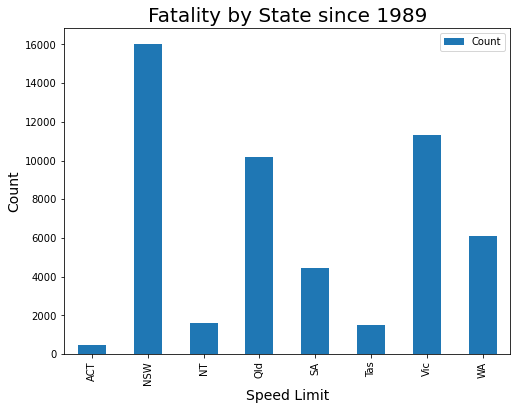

In [10]:
# capture state and Crash ID into new dataframe
state_year_df = clean_ardd[["State","Year"]]

# group by the state and count the number of fatality
groupby_state = state_year_df.groupby(["State"])

# calculate count
count = groupby_state["Year"].count()
                                       
# create a dataframe to hold State and Count
groupby_state_df = pd.DataFrame({"Count": count
                           })
# create a bar chart of the data
groupby_state_df.plot(kind="bar", figsize=(8,6))

# Set a Title and labels
plt.title(f"Fatality by State since {min_year}", fontsize=20)
plt.ylabel("Count",fontsize=14)
plt.xlabel("Speed Limit",fontsize=14)
plt.savefig('../output_data/cay_fatality_by_state.png', facecolor = 'w')
plt.show()

## Fatalities over time since 1989

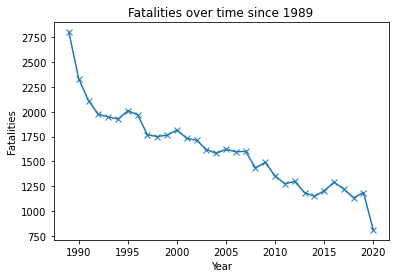

In [11]:
# capture Year and state into new dataframe
state_year_df = clean_ardd[["State","Year"]]

# group by the Year and count the number of fatality
groupby_state = state_year_df.groupby(["Year"])

# calculate count
count = groupby_state["Year"].count()
                                       
# create a dataframe to hold Year and Count
groupby_year_df = pd.DataFrame({"Count": count
                           })

plt.plot(groupby_year_df, marker = "x")
plt.title(f"Fatalities over time since {min_year}")
plt.ylabel("Fatalities")
plt.xlabel("Year")
plt.savefig('../output_data/cay_fatality_over_time.png', facecolor = 'w')
plt.show()

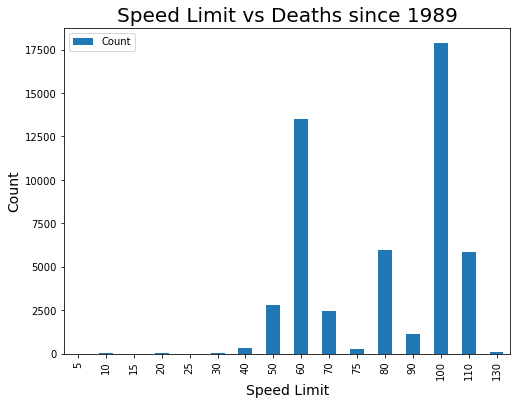

In [12]:
# capture Speed Limit and Crash ID into new dataframe
spdlmt_df = clean_ardd[["Speed Limit","Crash ID"]]

# remove "unknown", "unspecified" and "<40"
spdlmt_df = spdlmt_df[(spdlmt_df["Speed Limit"] != "Unknown") 
                      & (spdlmt_df["Speed Limit"] != "Unspecified") 
                     & (spdlmt_df["Speed Limit"] != "<40") ]

# uniform the data type to INT as some of it is in STR
spdlmt_df["Speed Limit"] = spdlmt_df["Speed Limit"].astype(int)


# group by the Speed Limit and count the number of fatality
groupby_spdlmt = spdlmt_df.groupby(["Speed Limit"])

# calculate count
count = groupby_spdlmt["Crash ID"].count()

# create a dataframe to hold speed limit and Count
groupby_spdlmt_df = pd.DataFrame({"Count": count
                           })
# create a bar chart of the data
groupby_spdlmt_df.plot(kind="bar", figsize=(8,6))

# Set a Title and labels
plt.title(f"Speed Limit vs Deaths since {min_year}", fontsize=20)
plt.ylabel("Count",fontsize=14)
plt.xlabel("Speed Limit",fontsize=14)
plt.savefig('output_data/cay_speed_limit_vs_deaths.png', facecolor = 'w')
plt.show()

##### CYRUS OLD CODE
# Commented out but kept for legacy purposes
#####

# # Max Speed vs. Fatality Rate - Cyrus
# # ---------------- Start ----------------

# # dependencies and Setup
# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd
# import scipy.stats as st
# from scipy.stats import linregress

# # raw data files
# max_spd_path = "data_raw/max_speed_limits_by_country.csv"
# death_by_type_path = "data_raw/deaths_by_vehicle_type.csv"
# tot_death_by_cty_path = "data_raw/total_deaths_by_country.csv"

# # read the mouse data and the death by type rate
# # add header = 1 to remove the extra row in the CSV file
# max_spd = pd.read_csv(max_spd_path, header=1)

# # header contains "Distribution of road traffic deaths by type of road user (%)"
# death_by_typ = pd.read_csv(death_by_type_path, header=1,)

# # header contains "Estimated number of road traffic deaths" & "Estimated road traffic death rate (per 100 000 population)
# tot_death_by_cty = pd.read_csv(tot_death_by_cty_path, header=1,)


# # combine the data into a single dataset
# combined_data = pd.merge(max_spd, tot_death_by_cty,on=["Country"], how = "inner")

# # remove the extra space in front of the columns
# combined_data = combined_data.rename(columns = {" Urban":"Urban Max Speed",
#                                                 " Rural":"Rural Max Speed", 
#                                                 " 2016":"Est. no. of road traffic deaths",
#                                                 " 2016.1":"Est. road traffic death rate (per 100 000 population)",
#                                                 })

# ## for column "Urban Max Speed" and "Rural Max Speed" 
# # drop all rows containing "?" or "No"
# combined_data = combined_data[~combined_data['Rural Max Speed'].isin(['?',"No","No "])]
# combined_data = combined_data[~combined_data['Urban Max Speed'].isin(['?',"No","No "])]
# # as the max speed column contains a range of numbers, this is to capture the last number in the cell
# combined_data["Rural Max Speed"] = combined_data["Rural Max Speed"].str.split().str[-1]
# combined_data["Urban Max Speed"] = combined_data["Urban Max Speed"].str.split().str[-1]
# # convert data type from string to integer
# combined_data['Rural Max Speed'] = combined_data['Rural Max Speed'].astype(int)
# combined_data['Urban Max Speed'] = combined_data['Urban Max Speed'].astype(int)

# ## for column "Est. no. of road traffic deaths"
# # remove all spaces within the column 
# combined_data['Est. no. of road traffic deaths'] = combined_data['Est. no. of road traffic deaths'].str.replace(" ","")
# # extract the numbers before the character "[" 
# combined_data['Est. no. of road traffic deaths'] = combined_data['Est. no. of road traffic deaths'].str.split('[').str[0]
# # convert data type from string to integer
# combined_data['Est. no. of road traffic deaths'] = combined_data['Est. no. of road traffic deaths'].astype(int)

# # display the data table for preview
# combined_data.head()

# # For me, only 12 countries couldn't show the correlation between speed limit and death rate
# # I included the code in case if we need to sort the country

# # # list the required contries for easier editting
# # countries = ["Australia",
# #              "United States of America",
# #              "United Kingdom of Great Britain and Northern Ireland",
# #              "Spain",
# #              "Sweden",
# #              "Germany",
# #              "Israel",
# #              "Canada",
# #              "Argentina",
# #              "Belgium",
# #              "Finland",
# #              "Greece",]

# # # select the required countries
# # combined_data = combined_data[combined_data["Country"].isin(countries)]

# # # display the data table for preview
# # combined_data.head()

# # platting the graph for Est. Road Traffic Death Rate vs. Rural Speed Limit
# x_values = combined_data['Rural Max Speed']
# y_values = combined_data['Est. road traffic death rate (per 100 000 population)']
# (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
# regress_values = x_values * slope + intercept
# line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
# plt.scatter(x_values,y_values)
# plt.plot(x_values,regress_values,"r-")
# plt.annotate(line_eq,(6,10),fontsize=15,color="red")
# plt.xlabel('Rural speed limit')
# plt.ylabel('Est. road traffic death rate\n(per 100 000 population)')
# plt.title("Est. Road Traffic Death Rate vs. Rural Speed Limit",fontsize=15)
# print(f"The r-squared is: {rvalue**2}")
# plt.show()

# # platting the graph for Est. Road Traffic Death Rate vs. Urban Speed Limit
# x_values = combined_data['Urban Max Speed']
# y_values = combined_data['Est. road traffic death rate (per 100 000 population)']
# (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
# regress_values = x_values * slope + intercept
# line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
# plt.scatter(x_values,y_values)
# plt.plot(x_values,regress_values,"r-")
# plt.annotate(line_eq,(6,10),fontsize=15,color="red")
# plt.xlabel('Urban speed limit')
# plt.ylabel('Est. road traffic death rate\n(per 100 000 population)')
# plt.title("Est. Road Traffic Death Rate vs. Urban Speed Limit",fontsize=15)
# print(f"The r-squared is: {rvalue**2}")
# plt.show()

# # ---------------- End ----------------
# # Max Speed vs. Fatality Rate - Cyrus

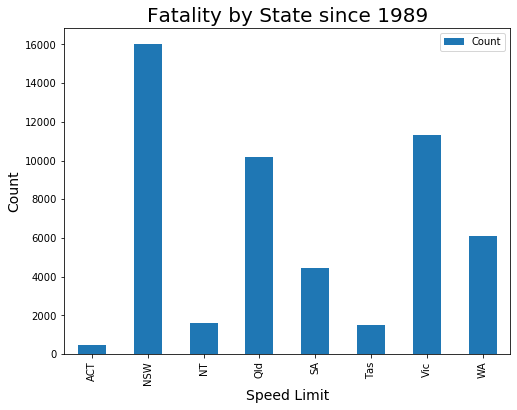

In [12]:
# capture state and Crash ID into new dataframe
state_year_df = clean_ardd[["State","Year"]]

# group by the state and count the number of fatality
groupby_state = state_year_df.groupby(["State"])

# calculate count
count = groupby_state["Year"].count()
                                       
# create a dataframe to hold State and Count
groupby_state_df = pd.DataFrame({"Count": count
                           })
# create a bar chart of the data
groupby_state_df.plot(kind="bar", figsize=(8,6))

# Set a Title and labels
plt.title(f"Fatality by State since {min_year}", fontsize=20)
plt.ylabel("Count",fontsize=14)
plt.xlabel("Speed Limit",fontsize=14)
plt.savefig('output_data/cay_fatality_by_state.png', facecolor = 'w')
plt.show()

## Fatalities over time since 1989

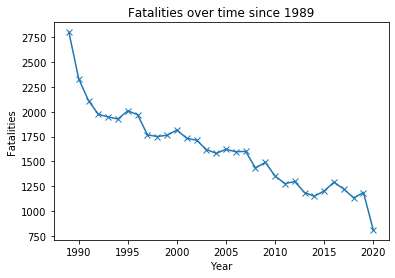

In [11]:
# capture Year and state into new dataframe
state_year_df = clean_ardd[["State","Year"]]

# group by the Year and count the number of fatality
groupby_state = state_year_df.groupby(["Year"])

# calculate count
count = groupby_state["Year"].count()
                                       
# create a dataframe to hold Year and Count
groupby_year_df = pd.DataFrame({"Count": count
                           })

plt.plot(groupby_year_df, marker = "x")
plt.title(f"Fatalities over time since {min_year}")
plt.ylabel("Fatalities")
plt.xlabel("Year")
plt.savefig('output_data/cay_fatality_over_time.png', facecolor = 'w')
plt.show()